1) Near Protocol

In [ ]:
import time
import random
import requests
import pandas as pd

# ——— CONFIGURATION ———
CRYPTO_LIST = ['BTC', 'ETH', 'SOL', 'XRP', 'ADA', 'RENDER', 'FET', 'NEAR', 'XYO', 'RIO']
TARGET_COUNT = 10000
SLEEP_BASE = 1.0  # seconds between requests
HEADERS = {
    'User-Agent': 'Mozilla/5.0 Chrome/39.0.2171.95 Safari/537.36'
}

def fetch_stocktwits_messages(symbol, target_count=TARGET_COUNT):
    base_url = f"https://api.stocktwits.com/api/2/streams/symbol/{symbol}.X.json"
    all_rows = []
    max_id = None

    while len(all_rows) < target_count:
        url = base_url if max_id is None else f"{base_url}?max={max_id}"
        resp = requests.get(url, headers=HEADERS)
        resp.raise_for_status()
        batch = resp.json().get('messages', [])
        if not batch:
            print(f"[{symbol}] No more messages available.")
            break

        for msg in batch:
            sentiment = (msg.get('entities') or {}).get('sentiment', {}).get('basic')
            all_rows.append({
                'date': msg['created_at'],
                'text': msg['body'],
                'sentiment': sentiment
            })
            if len(all_rows) >= target_count:
                break

        max_id = min(m['id'] for m in batch) - 1
        time.sleep(SLEEP_BASE + random.random() * 0.5)

    # Create dataframe
    df = pd.DataFrame(all_rows)
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    print(f"[{symbol}] Collected {len(df)} messages")

    # Export to Excel
    filename = f"{symbol}_messages.xlsx"
    df.to_excel(filename, index=False)
    print(f"[{symbol}] Saved to {filename}\n")
    return df

# ——— RUN THE LOOP FOR ALL CRYPTOS ———
for crypto in CRYPTO_LIST:
    try:
        fetch_stocktwits_messages(crypto)
    except Exception as e:
        print(f"Error fetching {crypto}: {e}")

No more messages available; stopping early.
Fetched 4859 messages (target was 10000)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4859 non-null   datetime64[ns]
 1   text       4859 non-null   object        
 2   sentiment  3075 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 114.0+ KB
None
Saved to Near_messages.xlsx


In [ ]:
import pandas as pd
import os

def clean_messages_for_crypto(symbol):
    input_file = f"{symbol}_messages.xlsx"
    output_file = f"{symbol}_with_sentiment_only.xlsx"

    # Charger le fichier
    if not os.path.exists(input_file):
        print(f"[{symbol}] Fichier non trouvé : {input_file}")
        return None

    df = pd.read_excel(input_file)

    # Vérification des colonnes
    if not {'date', 'text', 'sentiment'}.issubset(df.columns):
        print(f"[{symbol}] Colonnes incorrectes")
        return None

    # Filtrage des messages avec sentiment
    clean_df = df[df['sentiment'].notna()].reset_index(drop=True)

    # Nettoyage date
    if pd.api.types.is_datetime64tz_dtype(clean_df['date']):
        clean_df['date'] = clean_df['date'].dt.tz_localize(None)

    # Sauvegarde du résultat
    clean_df.to_excel(output_file, index=False)
    print(f"[{symbol}] {len(clean_df)} messages avec sentiment → sauvegardés dans {output_file}")
    return clean_df

# Liste des cryptos
CRYPTO_LIST = ['BTC', 'ETH', 'SOL', 'XRP', 'ADA', 'RENDER', 'FET', 'NEAR', 'XYO', 'RIO']

# Traitement en boucle
cleaned_data = {}
for symbol in CRYPTO_LIST:
    clean_df = clean_messages_for_crypto(symbol)
    if clean_df is not None:
        cleaned_data[symbol] = clean_df

Columns: ['date', 'text', 'sentiment']
Kept 3075 of 4859 messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3075 non-null   datetime64[ns]
 1   text       3075 non-null   object        
 2   sentiment  3075 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 72.2+ KB
None
                 date                                               text  \
0 2025-05-26 15:55:08                                            $NEAR.X   
1 2025-05-26 14:41:20  $NEAR.X I remember when this was $15 and had t...   
2 2025-05-25 22:59:57                                   $NEAR.X 🦠🤑🐸🦎🐊🐲🈯️   
3 2025-05-25 04:57:49  $NEAR.X dear MMs: why do you want me to avg down?   
4 2025-05-23 10:56:17  Good morning bulls $FET.X $ETH.X $ADA.X $NEAR....   

  sentiment  
0   Bullish  
1   Bullish  
2   Bullish  
3   Bullish  
4

<ipython-input-6-271335ef74b2>:17: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(clean_df['date']):


Filtered dataset saved to Near_with_sentiment_only.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prétraitement du texte (liens, mentions, ponctuation, minuscules)

In [ ]:
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Supprimer les liens
    text = re.sub(r"@\w+|\#", '', text)                  # Supprimer mentions et hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Ponctuation
    text = re.sub(r'\s+', ' ', text).strip()             # Espaces multiples
    return text

def apply_text_cleaning(clean_df):
    clean_df['clean_text'] = clean_df['text'].apply(clean_text)
    return clean_df

# Application en boucle pour tous les clean_df déjà traités
for symbol, df in cleaned_data.items():
    print(f"[{symbol}] Nettoyage des textes...")
    cleaned_data[symbol] = apply_text_cleaning(df)
    cleaned_data[symbol].to_excel(f"{symbol}_cleaned.xlsx", index=False)
    print(f"[{symbol}] Fichier nettoyé sauvegardé.")

,text,clean_text
0,$NEAR.X,nearx
1,$NEAR.X I remember when this was $15 and had t...,nearx i remember when this was 15 and had the ...
2,$NEAR.X 🦠🤑🐸🦎🐊🐲🈯️,nearx 🦠🤑🐸🦎🐊🐲🈯️
3,$NEAR.X dear MMs: why do you want me to avg down?,nearx dear mms why do you want me to avg down
4,Good morning bulls $FET.X $ETH.X $ADA.X $NEAR....,good morning bulls fetx ethx adax nearx solx 🟢🟢🟢👊


Création des jeux de données équilibré (500/500) et déséquilibré (800/200)

In [ ]:
# Map des sentiments : Bullish -> 1, Bearish -> 0
clean_df['label'] = clean_df['sentiment'].map({'Bullish': 1, 'Bearish': 0})

# Séparer les messages selon la classe
bullish = clean_df[clean_df['label'] == 1]
bearish = clean_df[clean_df['label'] == 0]

# Shuffle pour éviter les biais d’ordre
bullish = bullish.sample(frac=1, random_state=42)
bearish = bearish.sample(frac=1, random_state=42)

# Création des deux jeux
balanced_df   = pd.concat([bullish[:500], bearish[:500]]).sample(frac=1, random_state=42)
unbalanced_df = pd.concat([bullish[:800], bearish[:200]]).sample(frac=1, random_state=42)

# Aperçu
print("Équilibré :", balanced_df['label'].value_counts().to_dict())
print("Déséquilibré :", unbalanced_df['label'].value_counts().to_dict())

Équilibré : {1: 500, 0: 267}
Déséquilibré : {1: 800, 0: 200}


Modèle de base Naive Bayes (unigram) – Comparaison équilibré vs déséquilibré

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def train_and_evaluate(df_data, title=""):
    X_train, X_test, y_train, y_test = train_test_split(
        df_data['clean_text'], df_data['label'], test_size=0.2, random_state=42
    )

    vectorizer = CountVectorizer(ngram_range=(1,1))  # Unigram
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print(f"—— {title} ——")
    print(classification_report(y_test, y_pred, target_names=["Bearish", "Bullish"]))

# Test sur les deux datasets
train_and_evaluate(balanced_df, "Naive Bayes – Jeu équilibré")
train_and_evaluate(unbalanced_df, "Naive Bayes – Jeu déséquilibré")

—— Naive Bayes – Jeu équilibré ——
              precision    recall  f1-score   support

     Bearish       0.83      0.62      0.71        56
     Bullish       0.81      0.93      0.87        98

    accuracy                           0.82       154
   macro avg       0.82      0.78      0.79       154
weighted avg       0.82      0.82      0.81       154

—— Naive Bayes – Jeu déséquilibré ——
              precision    recall  f1-score   support

     Bearish       0.94      0.44      0.60        39
     Bullish       0.88      0.99      0.93       161

    accuracy                           0.89       200
   macro avg       0.91      0.71      0.76       200
weighted avg       0.89      0.89      0.87       200



Modèle ML

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [ ]:
def evaluate_model(model, df_data, model_name, ngram_range=(1,1)):
    print(f"\n—— {model_name} — ngram_range={ngram_range} ——")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        df_data['clean_text'], df_data['label'], test_size=0.2, random_state=42
    )

    # Vectorisation
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    # Entraînement
    model.fit(X_train_vec, y_train)

    # Prédiction
    y_pred = model.predict(X_test_vec)

    # Résultats
    print(classification_report(y_test, y_pred, target_names=["Bearish", "Bullish"]))

In [ ]:
# 1. Logistic Regression (Maximum Entropy)
evaluate_model(LogisticRegression(max_iter=1000), balanced_df, "Logistic Regression")

# 2. SVM
evaluate_model(LinearSVC(), balanced_df, "Support Vector Machine")

# 3. Random Forest
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), balanced_df, "Random Forest")

# 4. MLP (Neural Network)
evaluate_model(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), balanced_df, "Multilayer Perceptron")


—— Logistic Regression — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.81      0.52      0.63        56
     Bullish       0.77      0.93      0.84        98

    accuracy                           0.78       154
   macro avg       0.79      0.72      0.74       154
weighted avg       0.78      0.78      0.77       154


—— Support Vector Machine — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.73      0.62      0.67        56
     Bullish       0.80      0.87      0.83        98

    accuracy                           0.78       154
   macro avg       0.77      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154


—— Random Forest — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.79      0.59      0.67        56
     Bullish       0.79      0.91      0.85        98

    accuracy                           0.

In [ ]:
# Exemple avec Logistic Regression + bigrams
evaluate_model(LogisticRegression(max_iter=1000), balanced_df, "Logistic Regression (bigrams)", ngram_range=(1,2))


—— Logistic Regression (bigrams) — ngram_range=(1, 2) ——
              precision    recall  f1-score   support

     Bearish       0.81      0.54      0.65        56
     Bullish       0.78      0.93      0.85        98

    accuracy                           0.79       154
   macro avg       0.79      0.73      0.75       154
weighted avg       0.79      0.79      0.77       154



In [ ]:
import pandas as pd

# Chargement du fichier
price_df = pd.read_csv("near_prices.csv", sep=';')

# Vérifie le contenu
print(price_df.head())


         Date   Price Change %
0  05/25/2025  2.7552   -0.71%
1  05/18/2025  2.7751    3.03%
2  05/11/2025  2.6935  -19.64%
3  05/04/2025  3.3520   38.40%
4  04/27/2025  2.4220   -7.66%


In [ ]:
# Renommer
price_df.columns = ['date', 'price', 'change_percent']

# Convertir la date au format datetime
price_df['date'] = pd.to_datetime(price_df['date'])

# Trier les dates dans l’ordre croissant
price_df = price_df.sort_values('date').reset_index(drop=True)

# Calcul du rendement basé sur le prix
price_df['return'] = price_df['price'].pct_change()

# Affichage
print(price_df.head())

        date   price change_percent    return
0 2021-09-19  7.6210        -15.94%       NaN
1 2021-09-26  7.8101          2.48%  0.024813
2 2021-10-03  8.0329          2.85%  0.028527
3 2021-10-10  7.8409         -2.39% -0.023902
4 2021-10-17  9.3148         18.80%  0.187976


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Reentraîner le modèle Naive Bayes sur le jeu équilibré
vectorizer = CountVectorizer(ngram_range=(1,1))
X_balanced = vectorizer.fit_transform(balanced_df['clean_text'])
y_balanced = balanced_df['label']

model = MultinomialNB()
model.fit(X_balanced, y_balanced)

# Prédiction sur tout le jeu clean_df
X_all = vectorizer.transform(clean_df['clean_text'])
clean_df['predicted_sentiment'] = model.predict(X_all)

In [ ]:
# Extraire la semaine et l’année pour regrouper
clean_df['week'] = clean_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Moyenne du sentiment prédit par semaine
weekly_sentiment = clean_df.groupby('week')['predicted_sentiment'].mean().reset_index()
weekly_sentiment.columns = ['date', 'sentiment_score']

print(weekly_sentiment.head())

        date  sentiment_score
0 2021-08-16         0.916667
1 2021-08-30         1.000000
2 2021-09-06         0.952381
3 2021-09-13         0.714286
4 2021-09-20         1.000000


In [ ]:
print(price_df['date'].head())
print(price_df['date'].dtype)

0   2021-09-19
1   2021-09-26
2   2021-10-03
3   2021-10-10
4   2021-10-17
Name: date, dtype: datetime64[ns]
datetime64[ns]


In [ ]:
print(weekly_sentiment['date'].head())
print(weekly_sentiment['date'].dtype)

0   2021-08-16
1   2021-08-30
2   2021-09-06
3   2021-09-13
4   2021-09-20
Name: date, dtype: datetime64[ns]
datetime64[ns]


In [ ]:
weekly_sentiment['date'] = weekly_sentiment['date'] + pd.Timedelta(days=6)

In [ ]:
merged_df = pd.merge(price_df, weekly_sentiment, on='date', how='inner')
merged_df = merged_df.dropna()
merged_df.head()

,date,price,change_percent,return,sentiment_score
1,2021-09-26,7.8101,2.48%,0.024813,1.000
2,2021-10-03,8.0329,2.85%,0.028527,1.000
3,2021-10-10,7.8409,-2.39%,-0.023902,0.875
4,2021-10-17,9.3148,18.80%,0.187976,0.750
5,2021-10-24,10.4755,12.46%,0.124608,0.500


In [ ]:
correlation = merged_df[['return', 'sentiment_score']].corr()
print("Corrélation entre retour et sentiment :\n", correlation)

Corrélation entre retour et sentiment :
                    return  sentiment_score
return           1.000000         0.005477
sentiment_score  0.005477         1.000000


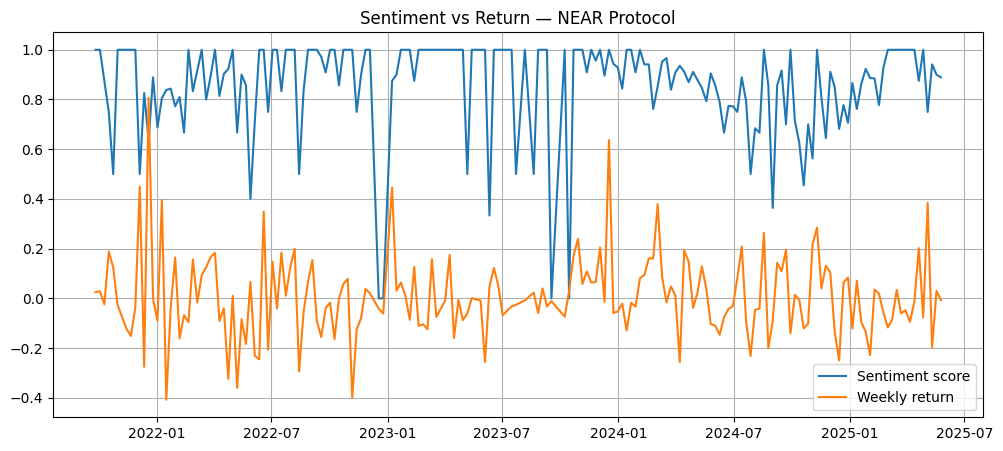

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(merged_df['date'], merged_df['sentiment_score'], label='Sentiment score')
plt.plot(merged_df['date'], merged_df['return'], label='Weekly return')
plt.legend()
plt.title("Sentiment vs Return — NEAR Protocol")
plt.grid()
plt.show()

Prediction for next prices

In [ ]:
# On prédit le rendement de la semaine suivante
merged_df['target_return'] = merged_df['return'].shift(-1)

# Entraînement sur return + sentiment_score
features_df = merged_df[['return', 'sentiment_score', 'target_return']].dropna()

X = features_df[['return', 'sentiment_score']]
y = features_df['target_return']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# Point de départ
last_row = merged_df.iloc[-1]
future_returns = []
future_prices = []

current_price = last_row['price']
current_return = last_row['return']
current_sentiment = last_row['sentiment_score']

for i in range(8):  # 8 semaines
    # Créer l'entrée pour le modèle
    X_input = [[current_return, current_sentiment]]

    # Prédiction du rendement
    predicted_return = model.predict(X_input)[0]
    future_returns.append(predicted_return)

    # Calcul du prix
    next_price = current_price * (1 + predicted_return)
    future_prices.append(next_price)

    # Mettre à jour les variables pour la semaine suivante
    current_return = predicted_return
    current_price = next_price
    # (on garde le même sentiment ici, ou tu peux estimer un futur score si tu veux)

# Création du DataFrame résultat
import pandas as pd

future_weeks = pd.date_range(start=last_row['date'] + pd.Timedelta(weeks=1), periods=8, freq='W')
forecast_df = pd.DataFrame({
    'date': future_weeks,
    'predicted_return': future_returns,
    'predicted_price': future_prices
})

forecast_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

,date,predicted_return,predicted_price
0,2025-06-01,0.001869,2.760350
1,2025-06-08,-0.002047,2.754699
2,2025-06-15,-0.039209,2.646689
3,2025-06-22,-0.049330,2.516128
4,2025-06-29,-0.030636,2.439043
5,2025-07-06,0.086852,2.650880
6,2025-07-13,-0.002262,2.644882
7,2025-07-20,-0.039209,2.541178


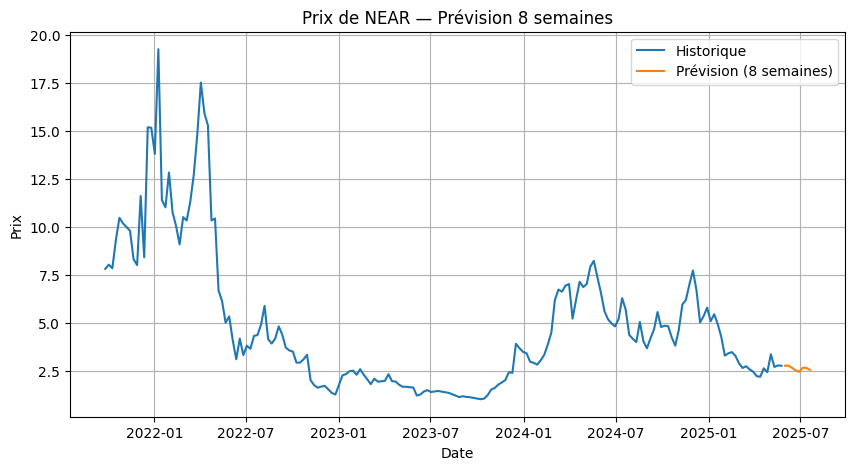

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(merged_df['date'], merged_df['price'], label="Historique")
plt.plot(forecast_df['date'], forecast_df['predicted_price'], label="Prévision (8 semaines)")
plt.legend()
plt.grid()
plt.title("Prix de NEAR — Prévision 8 semaines")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.show()

Prediction with XGBoost

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# On suppose que `merged_df` contient : 'return', 'sentiment_score', 'price', 'date'
merged_df['target_return'] = merged_df['return'].shift(-1)

# On garde uniquement les lignes complètes
features_df = merged_df[['return', 'sentiment_score', 'target_return']].dropna()

# Séparation des données
X = features_df[['return', 'sentiment_score']]
y = features_df['target_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred) ** 0.5
print("RMSE :", rmse)

RMSE : 0.16741847690021303


In [ ]:
from sklearn.metrics import mean_squared_error

# Évaluation
y_pred = xgb_model.predict(X_test)

print("R² :", r2_score(y_test, y_pred))

# RMSE manuelle sans paramètre squared
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print("RMSE :", rmse)

R² : -0.41094345793678166
RMSE : 0.16741847690021303


In [ ]:
from datetime import timedelta

# Dernière observation connue
last_row = merged_df.iloc[-1]

future_returns = []
future_prices = []

current_price = last_row['price']
current_return = last_row['return']
current_sentiment = last_row['sentiment_score']

for i in range(8):
    X_input = [[current_return, current_sentiment]]
    predicted_return = xgb_model.predict(X_input)[0]
    future_returns.append(predicted_return)

    next_price = current_price * (1 + predicted_return)
    future_prices.append(next_price)

    # Mise à jour
    current_return = predicted_return
    current_price = next_price

# Génération des dates futures
future_weeks = pd.date_range(start=last_row['date'] + pd.Timedelta(weeks=1), periods=8, freq='W')

# Construction du DataFrame
forecast_xgb = pd.DataFrame({
    'date': future_weeks,
    'predicted_return': future_returns,
    'predicted_price': future_prices
})

forecast_xgb

,date,predicted_return,predicted_price
0,2025-06-01,0.013410,2.792147
1,2025-06-08,-0.034099,2.696937
2,2025-06-15,0.096233,2.956473
3,2025-06-22,0.056537,3.123624
4,2025-06-29,0.075893,3.360684
5,2025-07-06,0.056537,3.550688
6,2025-07-13,0.075893,3.820159
7,2025-07-20,0.056537,4.036141


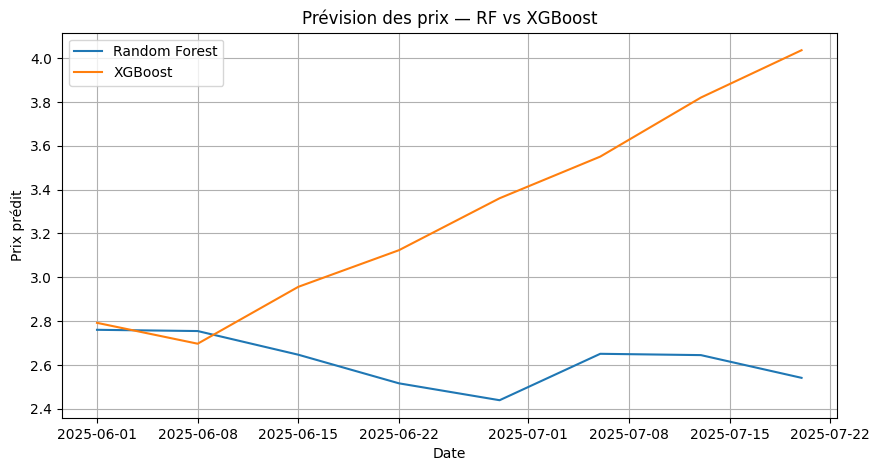

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_df['date'], forecast_df['predicted_price'], label="Random Forest")
plt.plot(forecast_xgb['date'], forecast_xgb['predicted_price'], label="XGBoost")
plt.xlabel("Date")
plt.ylabel("Prix prédit")
plt.title("Prévision des prix — RF vs XGBoost")
plt.legend()
plt.grid()
plt.show()

2) GFAL

In [ ]:
import time
import random
import json
import requests
import pandas as pd

# ——— CONFIGURATION ———
SYMBOL       = "GFAL.X"
TARGET_COUNT = 10000
SLEEP_BASE   = 1.0  # base seconds to sleep between requests

HEADERS = {
    'User-Agent': 'Mozilla/5.0 Chrome/39.0.2171.95 Safari/537.36'
}
BASE_URL = f"https://api.stocktwits.com/api/2/streams/symbol/{SYMBOL}.json"

# ——— FETCHING LOOP ———
all_rows = []
max_id   = None   # will become the “xxxxx” in ?max=xxxxx

while len(all_rows) < TARGET_COUNT:
    # build URL (use max on all but the first request)
    if max_id is None:
        url = BASE_URL
    else:
        url = f"{BASE_URL}?max={max_id}"

    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    batch = resp.json().get('messages', [])
    if not batch:
        print("No more messages available; stopping early.")
        break

    # extract date, text, sentiment from each message
    for msg in batch:
        entities  = msg.get('entities') or {}
        sentiment = (entities.get('sentiment') or {}).get('basic')
        all_rows.append({
            'date':      msg['created_at'],  # e.g. "2025-04-29T08:52:26+00:00"
            'text':      msg['body'],
            'sentiment': sentiment           # "Bullish", "Bearish", or None
        })
        if len(all_rows) >= TARGET_COUNT:
            break

    # set up the next page cursor (oldest id − 1)
    oldest_id = min(m['id'] for m in batch)
    max_id    = oldest_id - 1

    # polite pause + jitter
    time.sleep(SLEEP_BASE + random.random() * 0.5)

# ——— BUILD & CLEAN DATAFRAME ———
df = pd.DataFrame(all_rows, columns=['date','text','sentiment'])
df['date'] = pd.to_datetime(df['date'])           # to datetime64
df['date'] = df['date'].dt.tz_localize(None)      # drop timezone for Excel

print(f"Fetched {len(df)} messages (target was {TARGET_COUNT})")
print(df.info())

# ——— EXPORT TO EXCEL ———
output_file = "GFAL_messages.xlsx"
df.to_excel(output_file, index=False)
print(f"Saved to {output_file}")

No more messages available; stopping early.
Fetched 60 messages (target was 10000)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       60 non-null     datetime64[ns]
 1   text       60 non-null     object        
 2   sentiment  40 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.5+ KB
None
Saved to GFAL_messages.xlsx


Can't do anything with just 60 messages

3) Fetch AI

In [ ]:
import time
import random
import json
import requests
import pandas as pd

# ——— CONFIGURATION ———
SYMBOL       = "FET.X"
TARGET_COUNT = 10000
SLEEP_BASE   = 1.0  # base seconds to sleep between requests

HEADERS = {
    'User-Agent': 'Mozilla/5.0 Chrome/39.0.2171.95 Safari/537.36'
}
BASE_URL = f"https://api.stocktwits.com/api/2/streams/symbol/{SYMBOL}.json"

# ——— FETCHING LOOP ———
all_rows = []
max_id   = None   # will become the “xxxxx” in ?max=xxxxx

while len(all_rows) < TARGET_COUNT:
    # build URL (use max on all but the first request)
    if max_id is None:
        url = BASE_URL
    else:
        url = f"{BASE_URL}?max={max_id}"

    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    batch = resp.json().get('messages', [])
    if not batch:
        print("No more messages available; stopping early.")
        break

    # extract date, text, sentiment from each message
    for msg in batch:
        entities  = msg.get('entities') or {}
        sentiment = (entities.get('sentiment') or {}).get('basic')
        all_rows.append({
            'date':      msg['created_at'],  # e.g. "2025-04-29T08:52:26+00:00"
            'text':      msg['body'],
            'sentiment': sentiment           # "Bullish", "Bearish", or None
        })
        if len(all_rows) >= TARGET_COUNT:
            break

    # set up the next page cursor (oldest id − 1)
    oldest_id = min(m['id'] for m in batch)
    max_id    = oldest_id - 1

    # polite pause + jitter
    time.sleep(SLEEP_BASE + random.random() * 0.5)

# ——— BUILD & CLEAN DATAFRAME ———
df = pd.DataFrame(all_rows, columns=['date','text','sentiment'])
df['date'] = pd.to_datetime(df['date'])           # to datetime64
df['date'] = df['date'].dt.tz_localize(None)      # drop timezone for Excel

print(f"Fetched {len(df)} messages (target was {TARGET_COUNT})")
print(df.info())

# ——— EXPORT TO EXCEL ———
output_file = "FET_messages.xlsx"
df.to_excel(output_file, index=False)
print(f"Saved to {output_file}")

Fetched 10000 messages (target was 10000)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       10000 non-null  datetime64[ns]
 1   text       10000 non-null  object        
 2   sentiment  5628 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 234.5+ KB
None
Saved to FET_messages.xlsx


In [ ]:
# 1) (Re)load your near messages dataset
import pandas as pd

# If you already have `df` in memory, you can skip this line.
# Otherwise, load the Excel you exported earlier:
df = pd.read_excel("FET_messages.xlsx")

# 2) Confirm your DataFrame has the right columns
print("Columns:", df.columns.tolist())
# Should see: ['date', 'text', 'sentiment']

# 3) Filter out any rows with no sentiment tag
clean_df = df[df['sentiment'].notna()].reset_index(drop=True)
print(f"Kept {len(clean_df)} of {len(df)} messages")

# 4) (Optional) Drop timezone info if it’s still present
if pd.api.types.is_datetime64tz_dtype(clean_df['date']):
    clean_df['date'] = clean_df['date'].dt.tz_localize(None)

# 5) Inspect the filtered DataFrame
print(clean_df.info())
print(clean_df.head())

# 6) Save the result back to Excel
output_file = "FET_with_sentiment_only.xlsx"
clean_df.to_excel(output_file, index=False)
print(f"Filtered dataset saved to {output_file}")

# 7) (Colab) Download link
from google.colab import files
files.download(output_file)

Columns: ['date', 'text', 'sentiment']
Kept 5628 of 10000 messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5628 entries, 0 to 5627
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5628 non-null   datetime64[ns]
 1   text       5626 non-null   object        
 2   sentiment  5628 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 132.0+ KB
None
                 date                                               text  \
0 2025-05-26 18:02:02  $PEAQ.X $FET.X \n\n https://x.com/peaq/status/...   
1 2025-05-26 13:40:14                                 $FET.X back to\n$1   
2 2025-05-26 13:23:18                               $FET.X flip that SMA   
3 2025-05-26 13:17:17                                 $FET.X wants to 🚀🚀   
4 2025-05-26 09:42:34  $FET.X up 13% since this post lol. Hes a bulli...   

  sentiment  
0   Bullish  
1   Bullish  
2   Bullish  
3   Bullish  

<ipython-input-44-963eaa01c9a9>:17: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(clean_df['date']):


Filtered dataset saved to FET_with_sentiment_only.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def clean_text(text):
    text = str(text).lower()  # S'assure que c'est une chaîne
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)         # Supprimer les liens
    text = re.sub(r"@\w+|\#", '', text)                         # Supprimer les mentions/hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer ponctuation
    text = re.sub(r'\s+', ' ', text).strip()                    # Espaces multiples
    return text

clean_df['clean_text'] = clean_df['text'].apply(clean_text)
clean_df[['text', 'clean_text']].head()

,text,clean_text
0,$PEAQ.X $FET.X \n\n https://x.com/peaq/status/...,peaqx fetx
1,$FET.X back to\n$1,fetx back to 1
2,$FET.X flip that SMA,fetx flip that sma
3,$FET.X wants to 🚀🚀,fetx wants to 🚀🚀
4,$FET.X up 13% since this post lol. Hes a bulli...,fetx up 13 since this post lol hes a bullish i...


In [ ]:
# Map des sentiments : Bullish -> 1, Bearish -> 0
clean_df['label'] = clean_df['sentiment'].map({'Bullish': 1, 'Bearish': 0})

# Séparer les messages selon la classe
bullish = clean_df[clean_df['label'] == 1]
bearish = clean_df[clean_df['label'] == 0]

# Shuffle pour éviter les biais d’ordre
bullish = bullish.sample(frac=1, random_state=42)
bearish = bearish.sample(frac=1, random_state=42)

# Création des deux jeux
balanced_df   = pd.concat([bullish[:500], bearish[:500]]).sample(frac=1, random_state=42)
unbalanced_df = pd.concat([bullish[:800], bearish[:200]]).sample(frac=1, random_state=42)

# Aperçu
print("Équilibré :", balanced_df['label'].value_counts().to_dict())
print("Déséquilibré :", unbalanced_df['label'].value_counts().to_dict())

Équilibré : {0: 500, 1: 500}
Déséquilibré : {1: 800, 0: 200}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def train_and_evaluate(df_data, title=""):
    X_train, X_test, y_train, y_test = train_test_split(
        df_data['clean_text'], df_data['label'], test_size=0.2, random_state=42
    )

    vectorizer = CountVectorizer(ngram_range=(1,1))  # Unigram
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print(f"—— {title} ——")
    print(classification_report(y_test, y_pred, target_names=["Bearish", "Bullish"]))

# Test sur les deux datasets
train_and_evaluate(balanced_df, "Naive Bayes – Jeu équilibré")
train_and_evaluate(unbalanced_df, "Naive Bayes – Jeu déséquilibré")

—— Naive Bayes – Jeu équilibré ——
              precision    recall  f1-score   support

     Bearish       0.79      0.74      0.76       100
     Bullish       0.75      0.80      0.78       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

—— Naive Bayes – Jeu déséquilibré ——
              precision    recall  f1-score   support

     Bearish       0.86      0.46      0.60        39
     Bullish       0.88      0.98      0.93       161

    accuracy                           0.88       200
   macro avg       0.87      0.72      0.76       200
weighted avg       0.88      0.88      0.87       200



In [ ]:
def evaluate_model(model, df_data, model_name, ngram_range=(1,1)):
    print(f"\n—— {model_name} — ngram_range={ngram_range} ——")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        df_data['clean_text'], df_data['label'], test_size=0.2, random_state=42
    )

    # Vectorisation
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    # Entraînement
    model.fit(X_train_vec, y_train)

    # Prédiction
    y_pred = model.predict(X_test_vec)

    # Résultats
    print(classification_report(y_test, y_pred, target_names=["Bearish", "Bullish"]))

In [ ]:
# 1. Logistic Regression (Maximum Entropy)
evaluate_model(LogisticRegression(max_iter=1000), balanced_df, "Logistic Regression")

# 2. SVM
evaluate_model(LinearSVC(), balanced_df, "Support Vector Machine")

# 3. Random Forest
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), balanced_df, "Random Forest")

# 4. MLP (Neural Network)
evaluate_model(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), balanced_df, "Multilayer Perceptron")


—— Logistic Regression — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.86      0.72      0.78       100
     Bullish       0.76      0.88      0.81       100

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200


—— Support Vector Machine — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.80      0.74      0.77       100
     Bullish       0.76      0.82      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


—— Random Forest — ngram_range=(1, 1) ——
              precision    recall  f1-score   support

     Bearish       0.87      0.71      0.78       100
     Bullish       0.75      0.89      0.82       100

    accuracy                           0.

In [ ]:
import pandas as pd

# Chargement du fichier
price_df = pd.read_csv("Fet_prices.csv", sep=';')

# Vérifie le contenu
print(price_df.head())

         Date  Price Change %
0  05/25/2025  0.877    2.81%
1  05/18/2025  0.853   14.34%
2  05/11/2025  0.746  -17.75%
3  05/04/2025  0.907   32.60%
4  04/27/2025  0.684  -12.31%


In [ ]:
# Renommer les colonnes
price_df.columns = ['date', 'price', 'change_percent']

# Convertir la date
price_df['date'] = pd.to_datetime(price_df['date'])

# Trier par date croissante
price_df = price_df.sort_values('date').reset_index(drop=True)

# Calcul du rendement basé sur le prix
price_df['return'] = price_df['price'].pct_change()

# Affichage
print(price_df.head())

        date   price change_percent    return
0 2019-03-31  0.1997         -2.59%       NaN
1 2019-04-07  0.1921         -3.81% -0.038057
2 2019-04-14  0.2293         19.36%  0.193649
3 2019-04-21  0.1509        -34.19% -0.341910
4 2019-04-28  0.1241        -17.76% -0.177601


In [ ]:
# Extraire la semaine
clean_df['week'] = clean_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Moyenne du sentiment par semaine (Bullish = 1, Bearish = 0)
weekly_sentiment = clean_df.groupby('week')['label'].mean().reset_index()
weekly_sentiment.columns = ['date', 'sentiment_score']

# Vérification
print(weekly_sentiment.head())

        date  sentiment_score
0 2024-04-08         0.961538
1 2024-04-15         0.987578
2 2024-04-22         1.000000
3 2024-04-29         0.981132
4 2024-05-06         1.000000


In [ ]:
# Décaler les dates du sentiment (de lundi à dimanche)
weekly_sentiment['date'] = weekly_sentiment['date'] + pd.Timedelta(days=6)

# Fusion après décalage
merged_df = pd.merge(price_df, weekly_sentiment, on='date', how='inner')

# Supprimer les lignes manquantes
merged_df = merged_df.dropna()

print(merged_df.head())

        date   price change_percent    return  sentiment_score
0 2024-04-14  2.4911         28.11%  0.281101         0.961538
1 2024-04-21  2.1860        -12.25% -0.122476         0.987578
2 2024-04-28  2.1590         -1.24% -0.012351         1.000000
3 2024-05-05  2.1916          1.51%  0.015100         0.981132
4 2024-05-12  2.2784          3.96%  0.039606         1.000000


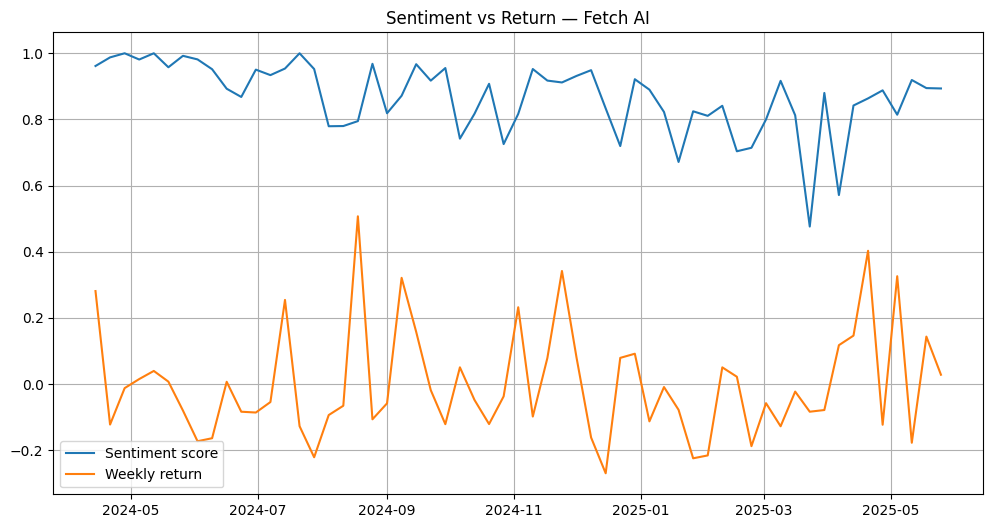

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged_df['date'], merged_df['sentiment_score'], label='Sentiment score')
plt.plot(merged_df['date'], merged_df['return'], label='Weekly return')
plt.title("Sentiment vs Return — Fetch AI")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Créer la target = return de la semaine suivante
merged_df['target_return'] = merged_df['return'].shift(-1)

# Garder les lignes complètes
features_df = merged_df[['return', 'sentiment_score', 'target_return']].dropna()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Séparation des features et de la target
X = features_df[['return', 'sentiment_score']]
y = features_df['target_return']

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred = xgb_model.predict(X_test)

# Évaluation
print("R² :", r2_score(y_test, y_pred))

# Calcul manuel du RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE :", rmse)

R² : -0.8536088760070197
RMSE : 0.24692883437275712


In [ ]:
# Dernière ligne
last_row = merged_df.iloc[-1]

# Générer les dates futures
import pandas as pd
future_weeks = pd.date_range(start=last_row['date'] + pd.Timedelta(weeks=1), periods=8, freq='W')

# Initialiser les valeurs
future_returns = []
future_prices = [last_row['price']]

# Boucle de prédiction
current_return = last_row['return']
current_sentiment = last_row['sentiment_score']

for _ in range(8):
    X_future = pd.DataFrame([[current_return, current_sentiment]], columns=['return', 'sentiment_score'])
    predicted_return = xgb_model.predict(X_future)[0]
    new_price = future_prices[-1] * (1 + predicted_return)

    future_returns.append(predicted_return)
    future_prices.append(new_price)

    current_return = predicted_return

# DataFrame final
forecast_df = pd.DataFrame({
    'date': future_weeks,
    'predicted_return': future_returns,
    'predicted_price': future_prices[1:]
})

forecast_df

,date,predicted_return,predicted_price
0,2025-06-01,-0.037362,0.844234
1,2025-06-08,-0.033330,0.816095
2,2025-06-15,-0.033330,0.788895
3,2025-06-22,-0.033330,0.762600
4,2025-06-29,-0.033330,0.737183
5,2025-07-06,-0.033330,0.712612
6,2025-07-13,-0.033330,0.688861
7,2025-07-20,-0.033330,0.665901


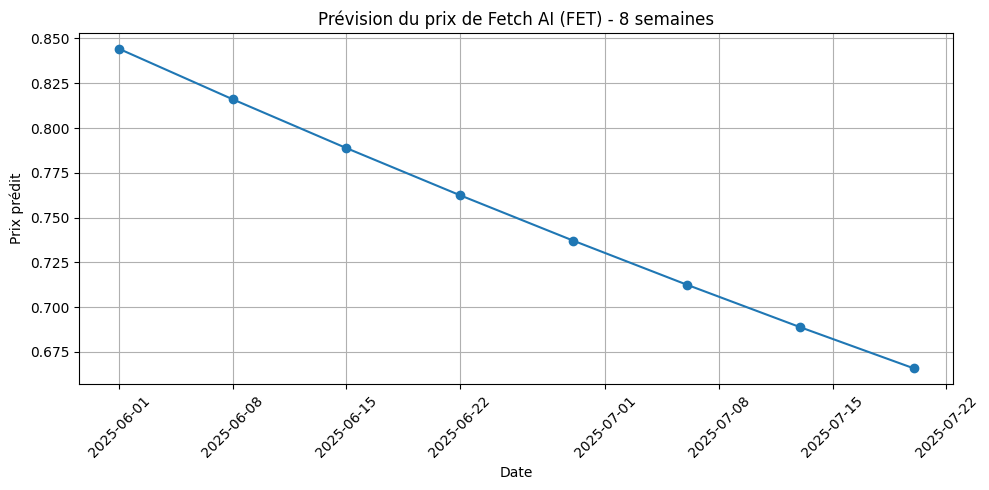

In [ ]:
import matplotlib.pyplot as plt

# Vérifie que 'forecast_df' contient bien les colonnes nécessaires
assert 'date' in forecast_df.columns and 'predicted_price' in forecast_df.columns

# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(forecast_df['date'], forecast_df['predicted_price'], marker='o', linestyle='-')
plt.title("Prévision du prix de Fetch AI (FET) - 8 semaines")
plt.xlabel("Date")
plt.ylabel("Prix prédit")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()